<a href="https://colab.research.google.com/github/satoru2001/Cat-Vs-Dogs/blob/master/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d biaiscience/dogs-vs-cats

 98% 801M/817M [00:08<00:00, 97.9MB/s]
100% 817M/817M [00:08<00:00, 99.1MB/s]


# Importing Libraries

In [4]:
import os
import zipfile
from shutil import copyfile
import random
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extracting Data from Zip file

In [5]:
loc_ref = '/content/dogs-vs-cats.zip'
zip_ref = zipfile.ZipFile(loc_ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Creating Folders to work with Keras

In [7]:
base = '/tmp'
train_parent = os.path.join(base,'training')
test_parent = os.path.join(base,'testing')
Cat_Train = os.path.join(train_parent,'train_Cats')
Dog_Train = os.path.join(train_parent,'train_Dogs')
Cat_Test = os.path.join(test_parent,'test_Cats')
Dog_Test = os.path.join(test_parent,'test_Dogs')
os.mkdir(train_parent)
os.mkdir(test_parent)
os.mkdir(Cat_Train)
os.mkdir(Cat_Test)
os.mkdir(Dog_Train)
os.mkdir(Dog_Test)

# Checking If any image is broken and separating cats and dogs

In [6]:
image_base_dir = '/tmp/train/train'
images_list = os.listdir(image_base_dir)
cats_list = []
dogs_list= []
for i in images_list:
  if 'cat' in i:
    if os.path.getsize(os.path.join(image_base_dir,i)):
      cats_list.append(i)
  else:
    if os.path.getsize(os.path.join(image_base_dir,i)):
      dogs_list.append(i)
print('Cat_number '+str(len(cats_list))+'\n'+'Dog_number '+str(len(dogs_list)))

Cat_number 12500
Dog_number 12500


# Transfering images to their respective folders

In [9]:
train = 0.9
test = 0.1
cats_list = random.sample(cats_list,len(cats_list))
dogs_list = random.sample(dogs_list,len(dogs_list))
cat_train = cats_list[:int(len(cats_list)*train)]
cat_test = cats_list[int(len(cats_list)*train):]
dog_train = dogs_list[:int(len(dogs_list)*train)]
dog_test= dogs_list[int(len(dogs_list)*train):]
for i in range(len(dog_train)):
  src_path = os.path.join(image_base_dir,cat_train[i])
  dst_path = os.path.join(Cat_Train,cat_train[i])
  copyfile(src_path,dst_path)
  src_path = os.path.join(image_base_dir,dog_train[i])
  dst_path = os.path.join(Dog_Train,dog_train[i])
  copyfile(src_path,dst_path)
for i in range(len(dog_test)):
  src_path = os.path.join(image_base_dir,cat_test[i])
  dst_path = os.path.join(Cat_Test,cat_test[i])
  copyfile(src_path,dst_path)
  src_path = os.path.join(image_base_dir,dog_test[i])
  dst_path = os.path.join(Dog_Test,dog_test[i])
  copyfile(src_path,dst_path)

In [10]:
print(len(os.listdir(Cat_Train)))
print(len(os.listdir(Cat_Test)))
print(len(os.listdir(Dog_Train)))
print(len(os.listdir(Dog_Test)))

11250
1250
11250
1250


# Checking the size of images from a sample image

In [11]:
img = load_img('/tmp/training/train_Cats/cat.0.jpg')
img = img_to_array(img)
print(img.shape)

(374, 500, 3)


# Ploting images

In [12]:
def plot_example_images(plt,animal):
  img_size = 300
  plt.figure(0,figsize=(12,20))
  ctr = 0
  for i in range(1,6):
    ctr+=1
    plt.subplot(1,5,ctr)
    img = load_img("/tmp/training/" + animal + "/" +os.listdir("/tmp/training/" + animal)[i], target_size=(img_size, img_size))
    plt.imshow(img)
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

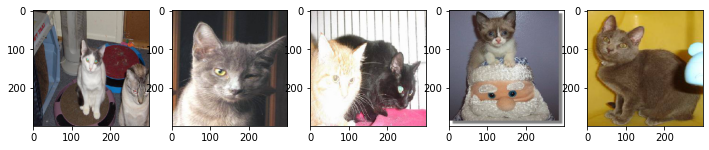

In [13]:
plot_example_images(plt,'train_Cats')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

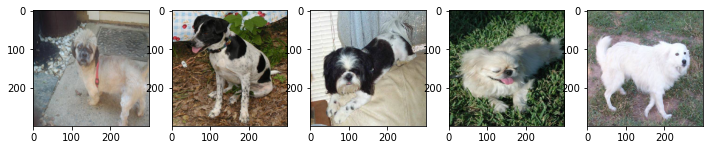

In [14]:
plot_example_images(plt,'train_Dogs')

# Creating Model ResNet50 with weights from imagenet***(Transfer Learning)***

In [15]:
pretrained_model = ResNet50(include_top=False,weights='imagenet',input_shape=(300,300,3))
for layer in pretrained_model.layers:
  layer.trainable=False
x = pretrained_model.output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Dense(1,activation='sigmoid')(x)
model = tensorflow.keras.models.Model(pretrained_model.input,outputs=x)
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
_____________________________

# Creating Data Generators 

In [16]:
TRAINING_DIR = train_parent
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    shear_range = 0.2,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 40,
    preprocessing_function=preprocess_input,
    )

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 10,
    target_size = (300,300),
    class_mode = 'binary',
    )

VALIDATION_DIR = test_parent
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 10,
    target_size = (300,300),
    class_mode = 'binary',
    )

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [19]:
model.fit_generator(train_generator,epochs=2,validation_data=validation_generator)

Epoch 1/2
2250/2250 [==============================] - 681s 303ms/step - loss: 2.5324 - accuracy: 0.9418 - val_loss: 1.1925 - val_accuracy: 0.9792
Epoch 2/2
2250/2250 [==============================] - 677s 301ms/step - loss: 2.8100 - accuracy: 0.9428 - val_loss: 1.1609 - val_accuracy: 0.9816


# Test your Own Images

In [36]:
from google.colab import files
uploaded = files.upload()
for images in uploaded:
  img = load_img(images,target_size=(300,300))
  img = img_to_array(img)
  img = img.reshape((1,) + img.shape)
  img = preprocess_input(img)
  ans = model.predict(img)
  print('The Given Pic Cat') if ans==0 else print('The Give Pic is Dog')
  !rm {images}

Saving download.jpeg to download (1).jpeg
The Given Pic Cat
